In [6]:
import sys,os,copy,glob,time
import numpy as np
sys.path.append(os.path.abspath('../../smodels'))
from smodels.tools.physicsUnits import fb
from smodels.tools import runtime
from smodels.tools import statistics
from smodels.tools.simplifiedLikelihoods import UpperLimitComputer, Data, LikelihoodComputer
runtime._experimental = True
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats,integrate,optimize,special
import matplotlib.font_manager

from smodels.experiment.databaseObj import Database
from tqdm.notebook import tqdm
import warnings
import shutil
import pickle

runtime._cap_likelihoods = False
runtime._drmax=100000.
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=2.0)
sns.set_palette(sns.color_palette("Paired"))


In [7]:
def getSRs():
    from smodels.experiment.databaseObj import Database
    db = Database ( "official" )
    ers = db.getExpResults( dataTypes=[ "efficiencyMap" ] )
    stats_ = []
    for er in ers:
        for ds in er.datasets:
            D = { "obsN": ds.dataInfo.observedN, "expectedBG": ds.dataInfo.expectedBG,
                  "bgError": ds.dataInfo.bgError, "upperLimit": ds.dataInfo.upperLimit,
                  "expectedUpperLimit": ds.dataInfo.expectedUpperLimit }
            stats_.append ( D )
    return stats_

In [8]:
stats_ = getSRs()

In [9]:
def getNorm(func, args, b, getMulim=False):
    err = 1.
    ctr = 0
    b = 2*b
    norm = integrate.quad(func, 0 , b, args, epsabs=0.,epsrel=1e-3)[0]
    while err > 0.01:
        ctr+=1
        if ctr > 50.:
            raise Exception("Could not compute norm within required precision")
        norm_old = norm
        b = b*1.2
        norm = integrate.quad(func, 0, b, args, epsabs=0., epsrel=1e-3)[0]
        if norm == 0.:
            continue
        err = abs(norm_old-norm)/norm
    if getMulim:
        return norm, b
    return norm

In [10]:
# ### Compute observed and expected upper limits
def run ( nobs, nExp, nExpErr, nsig, plotname=False ):
    """ run the procedure, with:
    :param nobs: number of observed
    :param nExp: number expected
    :param nExpErr: error on number expected
    """
    print ( "Starting run with nobs", nobs, "nExp", nExp )
    data = Data ( nobs, nExp, nExpErr**2, nsignal = nsig)
    computer = UpperLimitComputer ( 10000 )
    marginalize = False #True
    ULobs = computer.ulSigma ( data, marginalize=marginalize )
    
    ULexp = computer.ulSigma ( data, expected=True, marginalize=marginalize )
    ULexp_mod = ULexp / (1. - 0.75*((ULobs-ULexp)/(ULobs+ULexp)))
    print(r'Nobs = %1.2f, Nbg = %1.2f +- %1.2f, Nsig < %1.2f, Nsig (expected) < %1.2f'
         %(nobs,nExp,nExpErr,ULobs,ULexp))

    nsteps = 100 # 100
    
    mulim = abs(nobs-nExp+4*nExpErr)
    Lmax = 1
    while Lmax > .01:
        Lmax = statistics.likelihoodFromLimits(ULobs, ULexp, mulim, underfluct="norm_0")
        mulim = 1.2 * mulim
    muvals = np.linspace(0, mulim, nsteps )
    
    smllhd = LikelihoodComputer(data)
    
    norm_gauss = getNorm(smllhd.marginalizedLLHD1D, args=(False), b=max(ULobs,ULexp))
    norm_profiled = getNorm(smllhd.profileLikelihood, args=(False), b=max(ULobs,ULexp))
    
    llhds_app_norm0 = np.array([[mu, statistics.likelihoodFromLimits(ULobs, ULexp, mu, underfluct="norm_0")] for mu in muvals])
    llhds_full_profiled = np.array([[mu, smllhd.profileLikelihood(mu, nll=False)/norm_profiled] for mu in muvals])
    
    f = plt.figure(figsize=(10,6))
    plt.plot(llhds_full_profiled[:,0],llhds_full_profiled[:,1],label='Profile Likelihood',linewidth=3, color="brown")
    
    plt.plot(llhds_app_norm0[:,0],llhds_app_norm0[:,1],label='Truncated Gaussian', linestyle='--', linewidth=3)
    
    plt.legend()
    plt.xlabel(r'$\mu$')
    plt.ylabel(r'$L$')
    plt.title('$N_{obs} = %1.2f, N_{bg} = %1.2f \pm %1.2f, \mu_{obs}^{95\%%} = %1.2f, \mu_{exp}^{95\%%} = %1.2f, \Delta = %1.2f$'
              %(nobs,nExp,nExpErr,ULobs,ULexp,(ULobs-ULexp)/(ULobs+ULexp)),fontsize=14)
    if not plotname:
        plt.show()
        return
    
    plt.savefig("../../Thesis/graphics/"+str(plotname))
    plt.close()
    

In [11]:
j = 71
run(int(stats_[j]["obsN"]), stats_[j]["expectedBG"], stats_[j]["bgError"], 1, "llhds_overfluct")

Starting run with nobs 6 nExp 4.1
Nobs = 6.00, Nbg = 4.10 +- 1.90, Nsig < 8.52, Nsig (expected) < 6.18


In [12]:
j = 65
run(int(stats_[j]["obsN"]), stats_[j]["expectedBG"], stats_[j]["bgError"], 1, "llhds_underfluct")

Starting run with nobs 2 nExp 3.0
Nobs = 2.00, Nbg = 3.00 +- 1.50, Nsig < 4.50, Nsig (expected) < 5.45


In [13]:
if not os.path.exists("meta"):
    print("Run LikelihoodComparison first!")
else:
    print("Reading...")
    with open("meta/llhds_meta.pkl", "rb") as f:
        llhds_meta = pickle.load(f)
    print("Done.")

Reading...
Done.


In [14]:
def reldiff(ex, app):
    if(ex < 0 or app < 0): return(warnings.warn("Negative Value encountered"))
    if(ex+app == 0): return(0)
    return(2*(ex-app) / (app+ex))

In [15]:
modes_full = ["profiled"]
modes_app = ["norm_neg", "norm_0"]
moments = ["ev", "var", "mode"]

reldiffs = []

for i in range(len(llhds_meta)):
    tempdict = {}
    for mode_f in modes_full:
        for mode_a in modes_app:
            for moment in moments:
                try:
                    ex = llhds_meta[i][mode_f][moment]
                    app = llhds_meta[i][mode_a][moment]
                    tempdict[mode_f+"_vs_"+mode_a+"_"+moment] = reldiff(ex, app)
                except:
                    print(i, mode_f, mode_a, moment)
    reldiffs.append(tempdict)
        

In [16]:
###Means of relative Differences
means = {}
for moment in moments:
    for mode_f in modes_full:
        for mode_a in modes_app:
            mean = np.mean([reldiffs[x][mode_f+"_vs_"+mode_a+"_"+moment] for x in range(len(reldiffs))])
            means[mode_f+"_vs_"+mode_a+"_"+moment] = mean
            

In [17]:
ULobs, ULexp = [],[]
for i in range(len(stats_)):
    data = Data(stats_[i]["obsN"], stats_[i]["expectedBG"], stats_[i]["bgError"]**2, nsignal=1)
    computer = UpperLimitComputer ( 10000 )
    marginalize = False #True
    ULobs.append(computer.ulSigma ( data, marginalize=marginalize ))
    ULexp.append(computer.ulSigma ( data, expected=True, marginalize=marginalize ))


In [18]:
list_lower = [ULobs[x] <= ULexp[x] for x in range(len(stats_))]
list_greater = [ULobs[x] > ULexp[x] for x in range(len(stats_))]

lower = np.where(list_lower)[0]
greater = np.where(list_greater)[0]

In [19]:
def find_range(mode_f):
    range_={}
    for moment in moments:
        ma = -1e2
        mi = 1e2
        for mode_a in modes_app:
            ma_temp = max([reldiffs[x][mode_f+"_vs_"+mode_a+"_"+moment] for x in range(len(llhds_meta))])
            mi_temp = min([reldiffs[x][mode_f+"_vs_"+mode_a+"_"+moment] for x in range(len(llhds_meta))])
            if ma < ma_temp: ma = ma_temp
            if mi > mi_temp: mi = mi_temp
        range_[moment]=(mi,ma)
    return(range_)

In [20]:
names = {"ev":"Expected Value", "var":"Variance", "skew":"Skewness", "mode":"Mode",\
        "normal":"Poisson marginalized with Normal Error", "lognormal":"Poisson marginalized with Lognormal Error", "profiled":"Profile Likelihood",\
        "norm_0":"Truncated Normal with $\hat\mu  \geq 0$", "norm_neg":"Truncated Normal","mod":"Truncated Normal with modified $/sigma$"}

In [21]:
list_obsN0 = [stats_[x]["obsN"] == 0 for x in range(len(stats_))]
list_obsNnon0 = [stats_[x]["obsN"] > 0 for x in range(len(stats_))]
obsN0 = np.where(list_obsN0)[0]
obsNnon0 = np.where(list_obsNnon0)[0]

# Histograms unmodified

In [22]:
modes_full = ["profiled"]
moments = ["ev", "var", "mode"]
modes_app = ["norm_0"]
sns.set_palette(sns.color_palette("Paired"))


bins_=15
for mode_f in modes_full:
        nx = len(modes_app)
        ny = len(moments)
        fig, ax = plt.subplots(ny, nx, figsize=(8,10), constrained_layout=True)
        j = 0
        fig.supxlabel("")
        fig.supylabel("Number of Signal Regions")
        ranges = find_range(mode_f)
        for mode_a in modes_app:
            i = 0
            for moment in moments:
                if i == 0:
                    ax[i].set_title(names[mode_f]+"\nvs "+names[mode_a]+"\n", fontsize=25)
                else:
                    ax[i].set_title(" ",pad=10)
                obsNlower = [reldiffs[x][mode_f+"_vs_"+mode_a+"_"+moment] for x in lower]  
                obsNgreater = [reldiffs[x][mode_f+"_vs_"+mode_a+"_"+moment] for x in greater]
                hist_ = ax[i].hist([obsNgreater, obsNlower], bins=bins_, stacked=True, range=ranges[moment], label=["overfluct.","undefluct."])
                ax[i].legend()
                ax[i].set(xlabel="Relative Difference of "+names[moment]+"s")
                ax[i].yaxis.set_tick_params(labelbottom=True)
                maxn = max(hist_[0][1])
                ax[i].text(ranges[moment][0], maxn/10, "$\mu$ = {:.2f}".format(means[mode_f+"_vs_"+mode_a+"_"+moment]))
                i += 1
            j += 1
        #plt.show()
        plt.savefig("../../Thesis/graphics/"+mode_f+"_stacked")
        plt.close()
        

# Scatterplots unmodified

In [23]:
ylabels = {"ev":r"$2*\frac{ev_{full}-ev_{app}}{ev_{full}+ev_{app}}$",\
          "var":r"$2*\frac{Var_{full}-Var_{app}}{Var_{full}+Var_{app}}$",\
          "skew":r"$2*\frac{skew_{full}-skew_{app}}{skew_{full}+skew_{app}}$",\
          "mode":r"$2*\frac{mode_{full}-mode_{app}}{mode_{full}+mode_{app}}$"}

In [24]:
modes_full = ["profiled"]
moments = ["ev", "var", "mode"]
modes_app = ["norm_0"]



    
ULdiffs = []
for i in range(len(stats_)):
    ULdiffs.append(reldiff(ULobs[i], ULexp[i]))

for mode in modes_full:
    for mode_app in modes_app:
        for moment in moments:
            plt.figure(figsize=(13,8))
            reldiffs_moment = [reldiffs[x][mode+"_vs_"+mode_app+"_"+moment] for x in range(len(stats_))]
            
            ULdiffs_0 = [ULdiffs[i] for i in obsN0]
            reldiffs_0 = [reldiffs_moment[i] for i in obsN0]
            ULdiffs_non0 = [ULdiffs[i] for i in obsNnon0]
            reldiffs_non0 = [reldiffs_moment[i] for i in obsNnon0]
            plt.scatter(ULdiffs_0, reldiffs_0, color="orangered", label="$N_{obs} = 0$")
            plt.scatter(ULdiffs_non0, reldiffs_non0, color="royalblue", label="$N_{obs} > 0$")
            
            plt.legend()
            plt.xlabel(r"$2*\frac{\mu_{exp}^{95\%}-\mu_{obs}^{95\%}}{\mu_{exp}^{95\%}+\mu_{obs}^{95\%}}$")
            plt.ylabel(ylabels[moment])
            plt.grid()
            plt.title(names[mode]+" vs truncated Gaussian")
            #plt.show()
            plt.savefig("../../Thesis/graphics/"+str(mode+moment)+"_scatter.png")
            plt.close()

# Plots underfluct modified (loc<0+exp)

In [25]:
# ### Compute observed and expected upper limits
def run2 ( nobs, nExp, nExpErr, nsig, plotname=False ):
    """ run the procedure, with:
    :param nobs: number of observed
    :param nExp: number expected
    :param nExpErr: error on number expected
    """
    print ( "Starting run with nobs", nobs, "nExp", nExp )
    data = Data ( nobs, nExp, nExpErr**2, nsignal = nsig)
    computer = UpperLimitComputer ( 10000 )
    marginalize = False #True
    ULobs = computer.ulSigma ( data, marginalize=marginalize )

    ULexp = computer.ulSigma ( data, expected=True, marginalize=marginalize )
    ULexp_mod = ULexp / (1. - 0.75*((ULobs-ULexp)/(ULobs+ULexp)))
    print("mod = {:.3f}".format(ULexp_mod))
    print(r'Nobs = %1.2f, Nbg = %1.2f +- %1.2f, Nsig < %1.2f, Nsig (expected) < %1.2f'
         %(nobs,nExp,nExpErr,ULobs,ULexp))

    nsteps = 100 # 100
    
    mulim = abs(nobs-nExp+4*nExpErr)
    Lmax = 1
    while Lmax > .01:
        Lmax = statistics.likelihoodFromLimits(ULobs, ULexp, mulim, underfluct="norm_0")
        mulim = 1.2 * mulim
    muvals = np.linspace(0, mulim, nsteps )
    
    smllhd = LikelihoodComputer(data)
    
   
    norm_profiled = getNorm(smllhd.profileLikelihood, args=(False), b=max(ULobs,ULexp))
    
    llhds_app_norm0 = np.array([[mu, statistics.likelihoodFromLimits(ULobs, ULexp, mu, underfluct="norm_0")] for mu in muvals])
    llhds_app_norm_neg = np.array([[mu, statistics.likelihoodFromLimits(ULobs, ULexp, mu, underfluct="norm_neg")] for mu in muvals])
    llhds_app_exp = np.array([[mu, statistics.likelihoodFromLimits(ULobs, ULexp, mu, underfluct="exp")] for mu in muvals])
    
    llhds_full_profiled = np.array([[mu, smllhd.profileLikelihood(mu, nll=False)/norm_profiled] for mu in muvals])
    
    f = plt.figure(figsize=(10,6))
    plt.plot(llhds_full_profiled[:,0],llhds_full_profiled[:,1],label='Profile Likelihood',linewidth=3, color="brown")
    
    plt.plot(llhds_app_norm0[:,0],llhds_app_norm0[:,1],label='Truncated Gaussian', linestyle='--', linewidth=3)
    plt.plot(llhds_app_exp[:,0],llhds_app_exp[:,1],label='Exponential', linestyle='--', linewidth=3)
    plt.plot(llhds_app_norm_neg[:,0],llhds_app_norm_neg[:,1],label='Truncated Gaussian with $\hat\mu<0$', linestyle='--', linewidth=3)
    
    plt.legend()
    plt.xlabel(r'$\mu$')
    plt.ylabel(r'$L$')
    plt.title(r'$N_{obs} = %1.2f, N_{bg} = %1.2f \pm %1.2f, \mu_{obs}^{95\%%} = %1.2f, \mu_{exp}^{95\%%} = %1.2f, \Delta = %1.2f$'
              %(nobs,nExp,nExpErr,ULobs,ULexp,(ULobs-ULexp)/(ULobs+ULexp)),fontsize=14)
    if not plotname:
        plt.show()
        return
    
    plt.savefig("../../Thesis/graphics/"+str(plotname))
    plt.close()
    


In [26]:
j = 65
run2(int(stats_[j]["obsN"]), stats_[j]["expectedBG"], stats_[j]["bgError"], 1, "underfluct_mod")

Starting run with nobs 2 nExp 3.0
mod = 5.087
Nobs = 2.00, Nbg = 3.00 +- 1.50, Nsig < 4.50, Nsig (expected) < 5.45


In [27]:
j = 119
run2(int(stats_[j]["obsN"]), stats_[j]["expectedBG"], stats_[j]["bgError"], 1, "underfluct_mod_nobs0")

Starting run with nobs 0 nExp 2.5
mod = 3.736
Nobs = 0.00, Nbg = 2.50 +- 1.00, Nsig < 3.21, Nsig (expected) < 4.07


# Plot underfluct without exp

In [28]:
# ### Compute observed and expected upper limits
def run3 ( nobs, nExp, nExpErr, nsig, plotname=False ):
    """ run the procedure, with:
    :param nobs: number of observed
    :param nExp: number expected
    :param nExpErr: error on number expected
    """
    print ( "Starting run with nobs", nobs, "nExp", nExp )
    data = Data ( nobs, nExp, nExpErr**2, nsignal = nsig)
    computer = UpperLimitComputer ( 10000 )
    marginalize = False #True
    ULobs = computer.ulSigma ( data, marginalize=marginalize )

    ULexp = computer.ulSigma ( data, expected=True, marginalize=marginalize )
    ULexp_mod = ULexp / (1. - 0.75*((ULobs-ULexp)/(ULobs+ULexp)))
    print("mod = {:.3f}".format(ULexp_mod))
    print(r'Nobs = %1.2f, Nbg = %1.2f +- %1.2f, Nsig < %1.2f, Nsig (expected) < %1.2f'
         %(nobs,nExp,nExpErr,ULobs,ULexp))

    nsteps = 100 # 100
    
    mulim = abs(nobs-nExp+4*nExpErr)
    Lmax = 1
    while Lmax > .01:
        Lmax = statistics.likelihoodFromLimits(ULobs, ULexp, mulim, underfluct="norm_0")
        mulim = 1.2 * mulim
    muvals = np.linspace(0, mulim, nsteps )
    
    smllhd = LikelihoodComputer(data)
    
    norm_profiled = getNorm(smllhd.profileLikelihood, args=(False), b=max(ULobs,ULexp))
    
    llhds_app_norm0 = np.array([[mu, statistics.likelihoodFromLimits(ULobs, ULexp, mu, underfluct="norm_0")] for mu in muvals])
    llhds_app_norm_neg = np.array([[mu, statistics.likelihoodFromLimits(ULobs, ULexp, mu, underfluct="norm_neg")] for mu in muvals])
    llhds_full_profiled = np.array([[mu, smllhd.profileLikelihood(mu, nll=False)/norm_profiled] for mu in muvals])
    
    f = plt.figure(figsize=(10,6))
    
    plt.plot(llhds_full_profiled[:,0],llhds_full_profiled[:,1],label='Profile Likelihood',linewidth=3, color="brown")
    
    plt.plot(llhds_app_norm0[:,0],llhds_app_norm0[:,1],label='Truncated Gaussian', linestyle='--', linewidth=3)
    plt.plot(llhds_app_norm_neg[:,0],llhds_app_norm_neg[:,1],label='Truncated Gaussian with $\hat\mu<0$', linestyle='--', linewidth=3)
    
    plt.legend()
    plt.xlabel(r'$\mu$')
    plt.ylabel(r'$L$')
    plt.title(r'$N_{obs} = %1.2f, N_{bg} = %1.2f \pm %1.2f, \mu_{obs}^{95\%%} = %1.2f, \mu_{exp}^{95\%%} = %1.2f, \Delta = %1.2f$'
              %(nobs,nExp,nExpErr,ULobs,ULexp,(ULobs-ULexp)/(ULobs+ULexp)),fontsize=14)
    if not plotname:
        plt.show()
        return
    
    plt.savefig("../../Thesis/graphics/"+str(plotname))
    plt.close()
    


In [29]:
j = 65
run3(int(stats_[j]["obsN"]), stats_[j]["expectedBG"], stats_[j]["bgError"], 1, "underfluct_mod_no_exp")

Starting run with nobs 2 nExp 3.0
mod = 5.087
Nobs = 2.00, Nbg = 3.00 +- 1.50, Nsig < 4.50, Nsig (expected) < 5.45


# Hists: unmodified vs loc<0

In [30]:
modes_full = ["profiled"]
moments = ["ev", "var", "mode"]
modes_app = ["norm_0", "norm_neg"]

for mode_f in modes_full:
        nx = len(modes_app)
        ny = len(moments)
        fig, ax = plt.subplots(ny, nx, figsize=(16,10), constrained_layout=True, sharey="row")
        fig.supxlabel("")
        fig.supylabel("Number of Signal Regions", fontsize=25)
        j = 0
        ranges = find_range(mode_f)
        for mode_a in modes_app:
            i = 0
            for moment in moments:
                if i == 0:
                    ax[i,j].set_title(names[mode_f]+"\n vs "+names[mode_a]+"\n", fontsize=25)
                else:
                    ax[i,j].set_title(" ", pad=10)
                obsNlower = [reldiffs[x][mode_f+"_vs_"+mode_a+"_"+moment] for x in lower]  
                obsNgreater = [reldiffs[x][mode_f+"_vs_"+mode_a+"_"+moment] for x in greater]
                hist_ = ax[i,j].hist([obsNgreater, obsNlower], bins=bins_, stacked=True, range=ranges[moment], label=["overfluct.","underfluct"])
                ax[i,j].legend()
                ax[i,j].set(xlabel="Relative Difference of "+names[moment]+"s")
                ax[i,j].yaxis.set_tick_params(labelbottom=True)
                maxn = max(hist_[0][1])
                ax[i,j].text(ranges[moment][0], maxn/10, "$\mu$ = {:.2f}".format(means[mode_f+"_vs_"+mode_a+"_"+moment]))
                i += 1
            j += 1
       
        plt.savefig("../../Thesis/graphics/underfluct_modified_hist")
        plt.close()
        #plt.show()

# Scatterplot modified underflucts

In [31]:
modes_full = ["profiled"]
moments = ["ev", "var", "mode"]
modes_app = ["norm_neg"]



    
ULdiffs = []
for i in range(len(stats_)):
    ULdiffs.append(reldiff(ULobs[i], ULexp[i]))

for mode in modes_full:
    for mode_app in modes_app:
        for moment in moments:
            plt.figure(figsize=(13,8))
            reldiffs_moment = [reldiffs[x][mode+"_vs_"+mode_app+"_"+moment] for x in range(len(stats_))]
            
            ULdiffs_0 = [ULdiffs[i] for i in obsN0]
            reldiffs_0 = [reldiffs_moment[i] for i in obsN0]
            ULdiffs_non0 = [ULdiffs[i] for i in obsNnon0]
            reldiffs_non0 = [reldiffs_moment[i] for i in obsNnon0]
            plt.scatter(ULdiffs_0, reldiffs_0, color="orangered", label="$N_{obs} = 0$")
            plt.scatter(ULdiffs_non0, reldiffs_non0, color="royalblue", label="$N_{obs} > 0$")
            
            plt.legend()
            plt.xlabel(r"$2*\frac{\mu_{exp}^{95\%}-\mu_{obs}^{95\%}}{\mu_{exp}^{95\%}+\mu_{obs}^{95\%}}$")
            plt.ylabel(ylabels[moment])
            plt.grid()
            plt.title(names[mode]+" vs truncated Gaussian")
            #plt.show()
            plt.savefig("../../Thesis/graphics/modified_underflucts_scatter_"+str(moment))
            plt.close()

# Plots with modifier

In [32]:
mod_factors = [0, 0.25, 0.5, 0.75, 1, 2]

In [33]:
mod_factors = [0, 0.25, 0.5, 0.75, 1, 2]
# ### Compute observed and expected upper limits
def run3 ( nobs, nExp, nExpErr, nsig, plotname=False):
    """ run the procedure, with:
    :param nobs: number of observed
    :param nExp: number expected
    :param nExpErr: error on number expected
    """
    print ( "Starting run with nobs", nobs, "nExp", nExp )
    data = Data ( nobs, nExp, nExpErr**2, nsignal = nsig)
    computer = UpperLimitComputer ( 10000 )
    marginalize = False #True
    ULobs = computer.ulSigma ( data, marginalize=marginalize )

    ULexp = computer.ulSigma ( data, expected=True, marginalize=marginalize )
    
    print(r'Nobs = %1.2f, Nbg = %1.2f +- %1.2f, Nsig < %1.2f, Nsig (expected) < %1.2f'
         %(nobs,nExp,nExpErr,ULobs,ULexp))

    nsteps = 100 # 100
    
    mulim = abs(nobs-nExp+4*nExpErr)
    Lmax = 1
    while Lmax > .01:
        Lmax = statistics.likelihoodFromLimits(ULobs, ULexp, mulim, underfluct="norm_0")
        mulim = 1.2 * mulim
    muvals = np.linspace(0, mulim, nsteps )
    
    smllhd = LikelihoodComputer(data)
    
    norm_gauss = getNorm(smllhd.marginalizedLLHD1D, args=(False), b=max(ULobs,ULexp))
    norm_loggauss = getNorm(smllhd.marginalizedLLHD1D, args=(False, "lognormal"), b=max(ULobs,ULexp))
    norm_profiled = getNorm(smllhd.profileLikelihood, args=(False), b=max(ULobs,ULexp))
    
    llhds_full_norm = np.array([[mu, smllhd.marginalizedLLHD1D(mu, nll=False)/norm_gauss] for mu in muvals])
    llhds_full_profiled = np.array([[mu, smllhd.profileLikelihood(mu, nll=False)/norm_profiled] for mu in muvals])
    
    f = plt.figure(figsize=(10,6))
    plt.plot(llhds_full_profiled[:,0],llhds_full_profiled[:,1],label='Profile Likelihood',linewidth=3, color="brown")
    
    
    colors=["lightsteelblue", "slategrey", "royalblue", "blue", "navy", "black"]
    i=0
    for mf in mod_factors:
        ULexp_mod = ULexp / (1. - mf*((ULobs-ULexp)/(ULobs+ULexp)))
        llhds_app_mod = np.array([[mu, statistics.likelihoodFromLimits(ULobs, ULexp_mod, mu, underfluct="norm_neg")] for mu in muvals])
        plt.plot(llhds_app_mod[:,0],llhds_app_mod[:,1],label='Normal, modified $\sigma$, x={}'.format(mf), linestyle="--", linewidth=3, color=colors[i])
        i+=1    
            
    plt.legend()
    plt.xlabel(r'$\mu$')
    plt.ylabel(r'$L$')
    plt.title(r'$N_{obs} = %1.2f, N_{bg} = %1.2f \pm %1.2f, \mu_{obs}^{95\%%} = %1.2f, \mu_{exp}^{95\%%} = %1.2f, \Delta = %1.2f$'
              %(nobs,nExp,nExpErr,ULobs,ULexp,abs(ULobs-ULexp)/(ULobs+ULexp)),fontsize=14)
    if not plotname:
        plt.show()
        return
    
    
    plt.savefig("../../Thesis/graphics/mod_showcase")
    plt.show()
    plt.close()
    

Starting run with nobs 6 nExp 4.1
Nobs = 6.00, Nbg = 4.10 +- 1.90, Nsig < 8.52, Nsig (expected) < 6.18


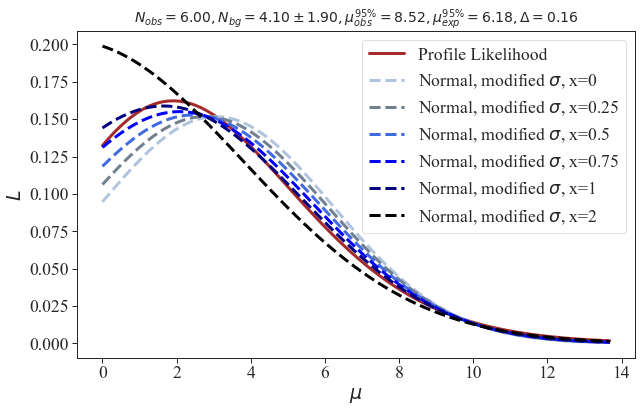

In [34]:
j = 71
run3(int(stats_[j]["obsN"]), stats_[j]["expectedBG"], stats_[j]["bgError"], 1, plotname=True)

# Modified Hists

In [75]:
mod_factors = [0, 0.25, 0.5, 0.6, 0.75, 1, 2]

In [76]:
# ### Compute observed and expected upper limits
def compare_methods_m ( nobs, nExp, nExpErr, nsig, mod_factor ):
    """ Compare Moments and mean of different Methods for calculating likelihoods out of given Data:
    :param nobs: number of observed
    :param nExp: number expected
    :param nExpErr: error on number expected
    """
    data = Data ( nobs, nExp, nExpErr**2, nsignal = nsig)
    computer = UpperLimitComputer ( 10000 )
    marginalize = False #True
    ULobs = computer.ulSigma ( data, marginalize=marginalize )

    ULexp = computer.ulSigma ( data, expected=True, marginalize=marginalize )
    if ULobs <= ULexp:
        ULexp_mod = ULexp
    else:
        ULexp_mod = ULexp / (1. - mod_factor*((ULobs-ULexp)/(ULobs+ULexp)))
    
    smllhd = LikelihoodComputer(data)
    
    res = {}
    
     modes_full = ["normal"]
    for mode in modes_full:
        norm, mulim = getNorm(smllhd.marginalizedLLHD1D, args=(False, mode), b=max(ULobs,ULexp), getMulim=True)
        llhd_full = lambda mu: smllhd.marginalizedLLHD1D(mu, nll=False, bg_error=mode)/norm
        res[mode] = num_moments(llhd_full, mulim)
    
    norm_profiled, mulim_profiled = getNorm(smllhd.profileLikelihood, args=(False), b=max(ULobs,ULexp), getMulim=True)
    llhd_profiled = lambda mu: smllhd.profileLikelihood(mu, nll=False)/norm_profiled
    res["profiled"] = num_moments(llhd_profiled, mulim_profiled)
    modes_app = ["norm_neg", "norm_0"]
    for mode in modes_app:
        res[mode] = statistics.llhdFromLimits_moments(ULobs, ULexp, underfluct=mode)
    res["mod"] = statistics.llhdFromLimits_moments(ULobs, ULexp_mod, underfluct="norm_neg")
    
    return res 

In [78]:
if not os.path.exists("meta_mod"):
    print("Run LikelihoodModifierComparison first!")
else:
    print("Reading...")
    with open("meta_mod/llhds_meta_mod.pkl", "rb") as f:
        llhds_meta_m = pickle.load(f)
    print("Done.")

Would you like to redo the meta analysis? (y/n)
n
Reading...
Done.


In [79]:
modes_full = ["profiled"]
modes_app = ["norm_neg", "norm_0", "mod"]
moments = ["ev", "var", "mode"]
mod_factors = [0,0.25,0.5,0.6,0.75,1,2]

reldiffs_mf = {}
for mf in mod_factors:
    reldiffs_mf[mf] = []
    for i in range(len(llhds_meta_m[mf])):
        tempdict = {}
        for mode_f in modes_full:
            for mode_a in modes_app:
                for moment in moments:
                    try:
                        ex = llhds_meta_m[mf][i][mode_f][moment]
                        app = llhds_meta_m[mf][i][mode_a][moment]
                        tempdict[mode_f+"_vs_"+mode_a+"_"+moment] = reldiff(ex, app)
                    except:
                        print(i, mode_f, mode_a, moment)
        reldiffs_mf[mf].append(tempdict)


In [80]:
###Means of relative Differences
mod_factors = [0,0.25,0.5,0.6,0.75,1,2]
means_mf = {}
for mf in mod_factors:
    means_mf[mf] = {}
    for moment in moments:
        for mode_f in modes_full:
            for mode_a in modes_app:
                mean = np.mean([reldiffs_mf[mf][x][mode_f+"_vs_"+mode_a+"_"+moment] for x in range(len(reldiffs))])
                means_mf[mf][mode_f+"_vs_"+mode_a+"_"+moment] = mean
            

In [82]:
def find_range_mf(mode_f):
    range_={}
    for moment in moments:
        ma = -1e2
        mi = 1e2
        for mode_a in modes_app:
            for mf in mod_factors:
                ma_temp = max([reldiffs_mf[mf][x][mode_f+"_vs_"+mode_a+"_"+moment] for x in range(len(llhds_meta_m[mf]))])
                mi_temp = min([reldiffs_mf[mf][x][mode_f+"_vs_"+mode_a+"_"+moment] for x in range(len(llhds_meta_m[mf]))])
                if ma < ma_temp: ma = ma_temp
                if mi > mi_temp: mi = mi_temp
        range_[moment]=(mi,ma)
    return(range_)

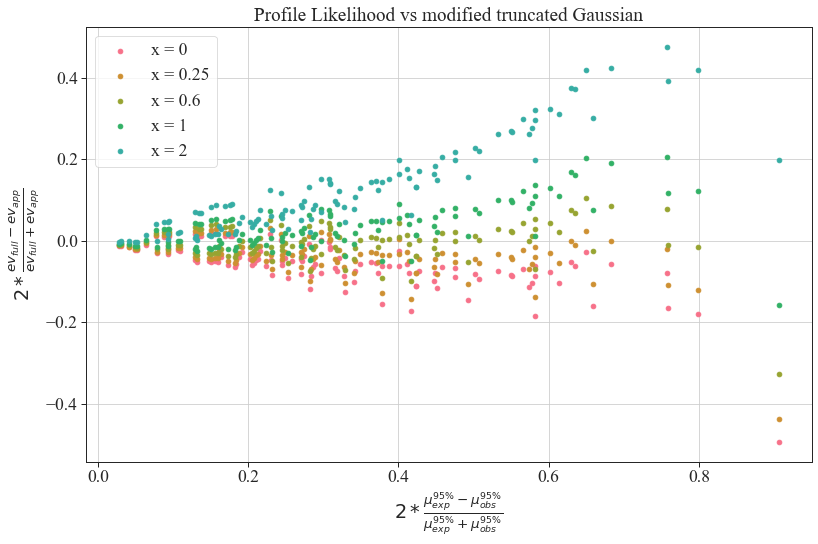

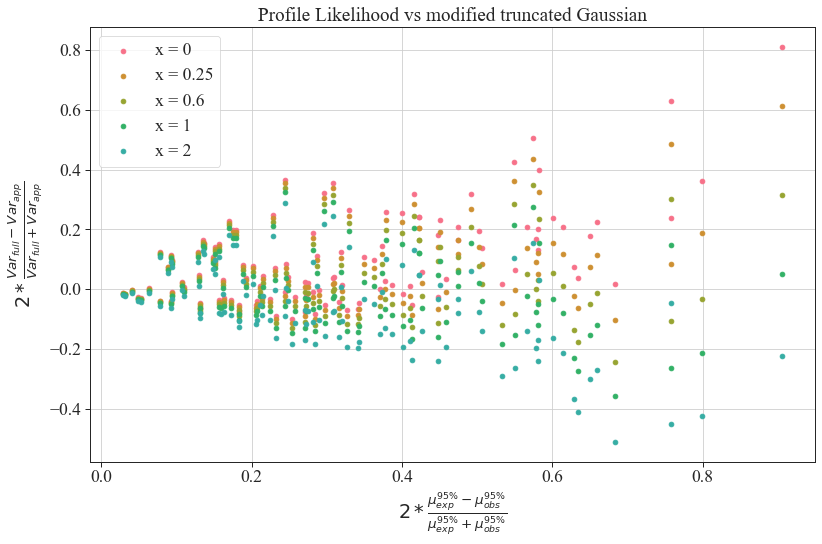

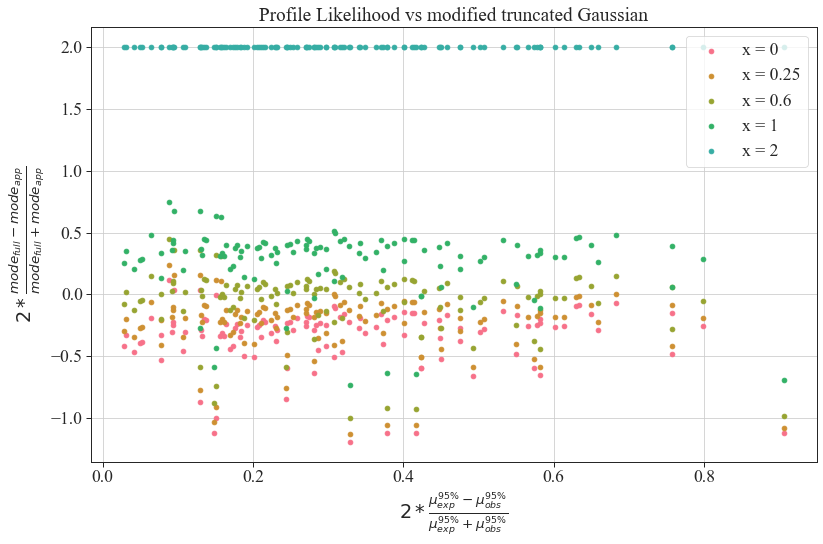

In [94]:
sns.set_palette(sns.color_palette("husl", 8))
mod_factors=[0,0.25,0.6,1,2]
#mod_factors=[0.6]

for mode in modes_full:
    for moment in moments:
        fig, ax = plt.subplots(figsize=(13,8))
        
        #reldiffs_moment = [reldiffs_mf[0][x][mode+"_vs_"+"mod"+"_"+moment] for x in range(len(stats_))]
        #ax.scatter(ULdiffs, reldiffs_moment, color="royalblue",label="x = 0")
        
        for mf in mod_factors:
            reldiffs_moment = [reldiffs_mf[mf][x][mode+"_vs_"+"mod"+"_"+moment] for x in range(len(stats_))]
            
            ULdiffs_greater = []
            reldiffs_moment_gr = []
            for i in range(len(ULdiffs)): 
                if ULdiffs[i] > 0:
                    ULdiffs_greater.append(ULdiffs[i])
                    reldiffs_moment_gr.append(reldiffs_moment[i])
                
            #ax.scatter(ULdiffs, reldiffs_moment, label="x = {}".format(mf))
            ax.scatter(ULdiffs_greater, reldiffs_moment_gr, label="x = {}".format(mf))
        
        
        plt.xlabel(r"$2*\frac{\mu_{exp}^{95\%}-\mu_{obs}^{95\%}}{\mu_{exp}^{95\%}+\mu_{obs}^{95\%}}$")
        plt.ylabel(ylabels[moment])
        ax.grid(True)
        plt.title(names[mode]+" vs modified truncated Gaussian")
        ax.legend()
        plt.savefig("../../Thesis/graphics/mod_scatter_"+str(mode+moment))
        #plt.show()
        plt.close()

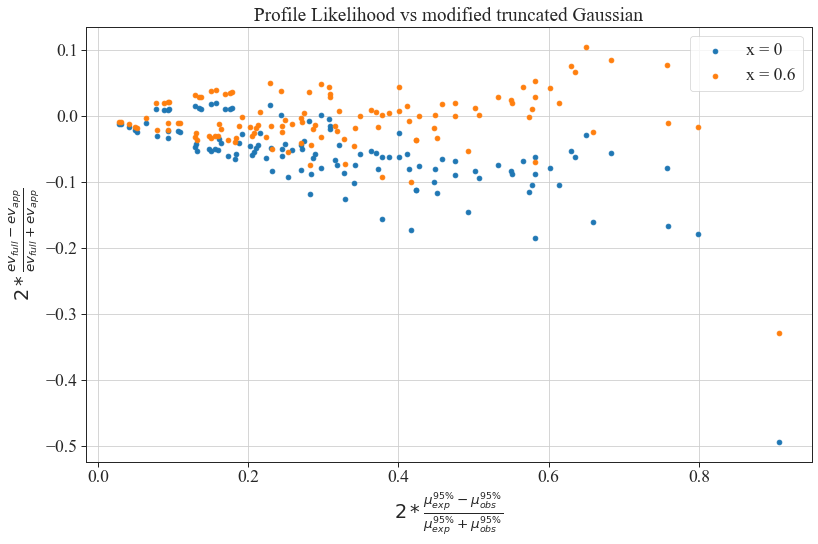

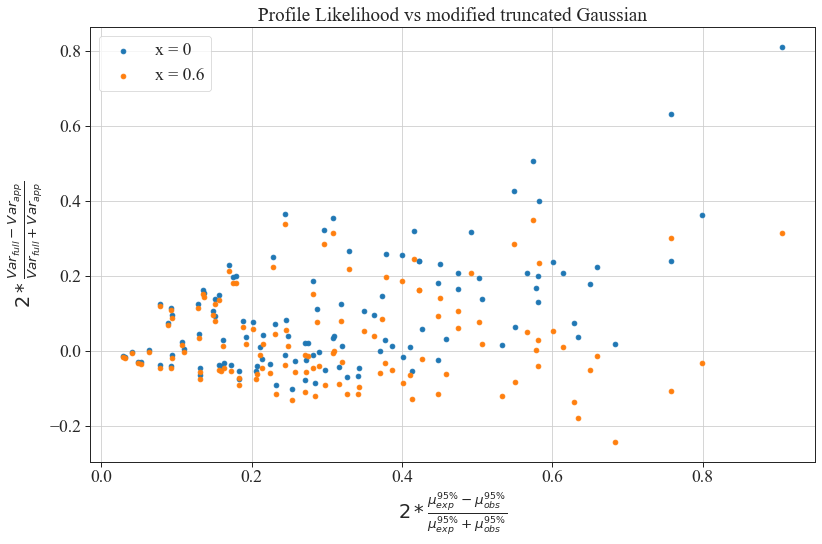

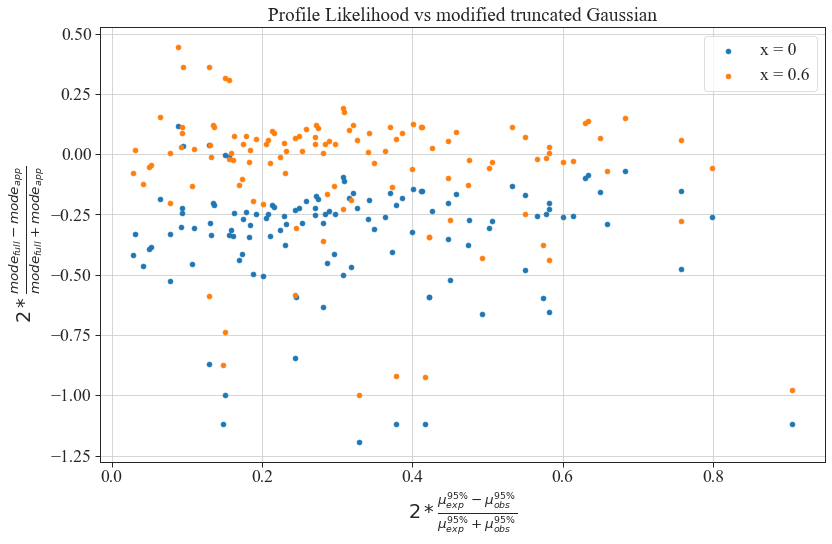

In [93]:
sns.set_palette(sns.color_palette("tab10"))
#mod_factors=[0,0.5,1,2]
mod_factors=[0,0.6]

for mode in modes_full:
    for moment in moments:
        fig, ax = plt.subplots(figsize=(13,8))
        
        #reldiffs_moment = [reldiffs_mf[0][x][mode+"_vs_"+"mod"+"_"+moment] for x in range(len(stats_))]
        #ax.scatter(ULdiffs, reldiffs_moment, color="royalblue",label="x = 0")
        
        for mf in mod_factors:
            reldiffs_moment = [reldiffs_mf[mf][x][mode+"_vs_"+"mod"+"_"+moment] for x in range(len(stats_))]
            
            ULdiffs_greater = []
            reldiffs_moment_gr = []
            for i in range(len(ULdiffs)): 
                if ULdiffs[i] > 0:
                    ULdiffs_greater.append(ULdiffs[i])
                    reldiffs_moment_gr.append(reldiffs_moment[i])
                
            #ax.scatter(ULdiffs, reldiffs_moment, label="x = {}".format(mf))
            ax.scatter(ULdiffs_greater, reldiffs_moment_gr, label="x = {}".format(mf))
        
        
        plt.xlabel(r"$2*\frac{\mu_{exp}^{95\%}-\mu_{obs}^{95\%}}{\mu_{exp}^{95\%}+\mu_{obs}^{95\%}}$")
        plt.ylabel(ylabels[moment])
        ax.grid(True)
        plt.title(names[mode]+" vs modified truncated Gaussian")
        ax.legend()
        #plt.savefig("./hists_mod/"+str(mode+moment))
        plt.savefig("../../Thesis/graphics/mod_scatter_x06+"+str(mode+moment))
        plt.show()
        plt.close()

In [99]:
sns.set_palette(sns.color_palette("tab10"))
modes_full = ["profiled"]
moments = ["ev", "var", "mode"]
modes_app = ["norm_0"]



    
ULdiffs = []
for i in range(len(stats_)):
    ULdiffs.append(reldiff(ULobs[i], ULexp[i]))

for mode in modes_full:
    for mode_app in modes_app:
        for moment in moments:
            plt.figure(figsize=(13,8))
            reldiffs_moment = [reldiffs[x][mode+"_vs_"+mode_app+"_"+moment] for x in range(len(stats_))]
            
            ULdiffs_greater = []
            reldiffs_moment_gr = []
            for i in range(len(ULdiffs)): 
                if ULdiffs[i] > 0:
                    ULdiffs_greater.append(ULdiffs[i])
                    reldiffs_moment_gr.append(reldiffs_moment[i])
                
            
            plt.scatter(ULdiffs_greater, reldiffs_moment_gr, label="unmodified truncated Gaussian")
            
            
            plt.legend()
            plt.xlabel(r"$2*\frac{\mu_{exp}^{95\%}-\mu_{obs}^{95\%}}{\mu_{exp}^{95\%}+\mu_{obs}^{95\%}}$")
            plt.ylabel(ylabels[moment])
            plt.grid()
            plt.title(names[mode]+" vs truncated Gaussian")
            #plt.show()
            plt.savefig("../../Thesis/graphics/"+str(mode+moment)+"_scatter_overfluct_unmodified.png")
            plt.close()

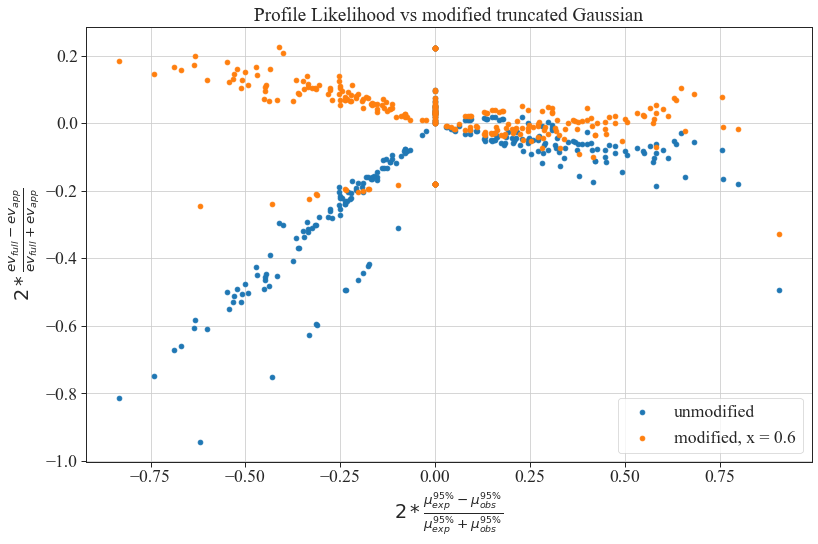

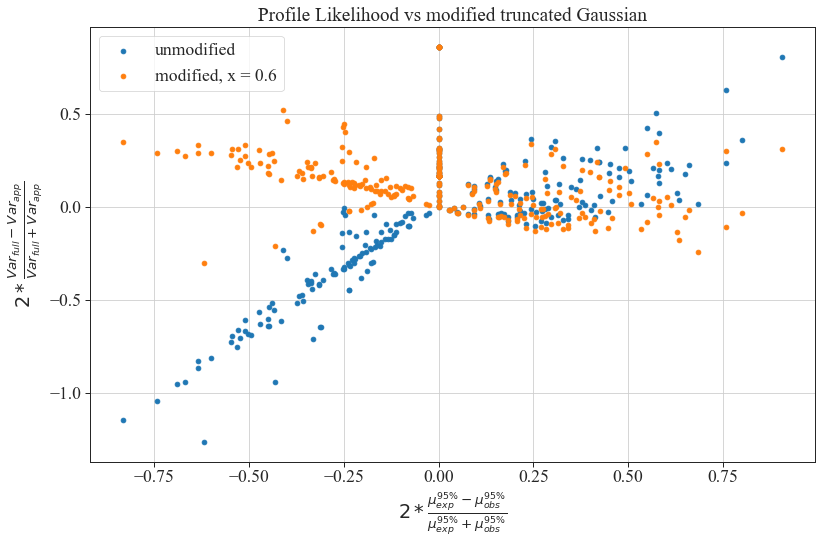

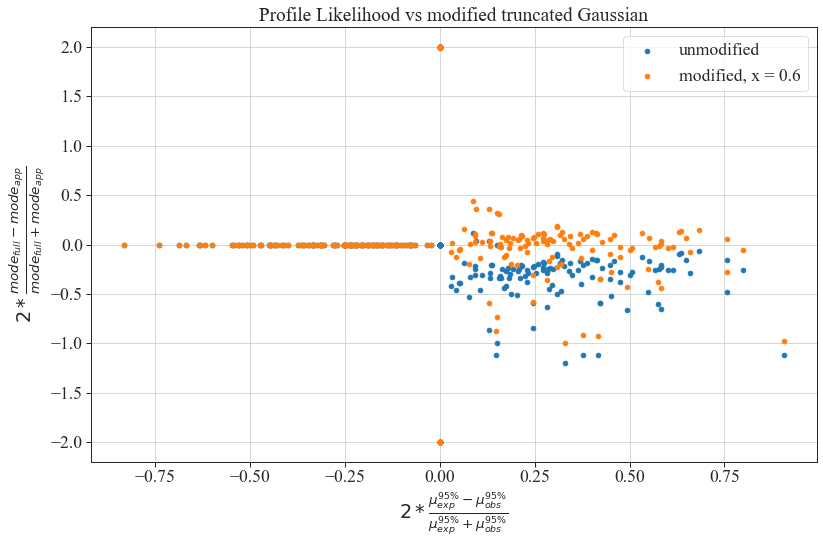

In [86]:
sns.set_palette(sns.color_palette("tab10"))
#mod_factors=[0.5,1,2]
mod_factors=[0.6]

for mode in modes_full:
    for moment in moments:
        fig, ax = plt.subplots(figsize=(13,8))
        
        for mf in mod_factors:
            reldiffs_moment_ = [reldiffs_mf[mf][x][mode+"_vs_"+"mod"+"_"+moment] for x in range(len(stats_))]
            reldiffs_moment = [reldiffs[x][mode+"_vs_norm_0_"+moment] for x in range(len(stats_))]
            
            ax.scatter(ULdiffs, reldiffs_moment, label="unmodified")
            ax.scatter(ULdiffs, reldiffs_moment_, label="modified, x = {}".format(mf))
           
            
        
        plt.xlabel(r"$2*\frac{\mu_{exp}^{95\%}-\mu_{obs}^{95\%}}{\mu_{exp}^{95\%}+\mu_{obs}^{95\%}}$")
        plt.ylabel(ylabels[moment])
        ax.grid(True)
        plt.title(names[mode]+" vs modified truncated Gaussian")
        ax.legend()
        #plt.savefig("./hists_mod/"+str(mode+moment))
        plt.show()
        plt.close()

# Final Hist

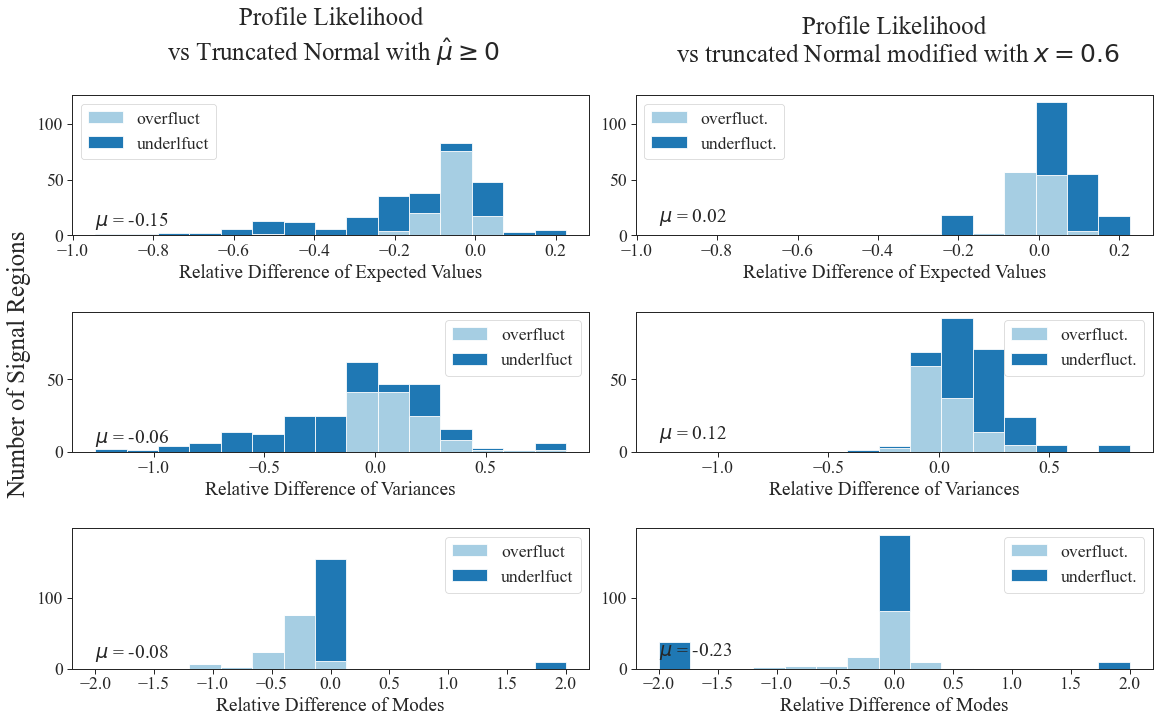

In [88]:
modes_full = ["profiled"]
moments = ["ev", "var", "mode"]
modes_app = ["norm_0", "mod"]
sns.set_palette(sns.color_palette("Paired"))

for mode_f in modes_full:
    nx = 2
    ny = len(moments)
    fig, ax = plt.subplots(ny, nx, figsize=(16,10), constrained_layout=True, sharey="row")
    fig.supxlabel("")
    fig.supylabel("Number of Signal Regions", fontsize=25)
    ranges = find_range_mf(mode_f)
    i = 0
    mf = 0
    for moment in moments:
        if i == 0:
            ax[i,0].set_title(names[mode_f]+"\n vs "+names["norm_0"]+"\n", fontsize=25)
        else:
            ax[i,0].set_title(" ", pad=10)
        obsNlower = [reldiffs[x]["profiled_vs_norm_0_"+moment] for x in lower]  
        obsNgreater = [reldiffs[x]["profiled_vs_norm_0_"+moment] for x in greater]
        hist_ = ax[i,0].hist([obsNgreater, obsNlower], bins=bins_, stacked=True, range=ranges[moment], label=["overfluct","underlfuct"])
        ax[i,0].legend()
        ax[i,0].set(xlabel="Relative Difference of "+names[moment]+"s")
        ax[i,0].yaxis.set_tick_params(labelbottom=True)
        maxn = max(hist_[0][1])
        ax[i,0].text(ranges[moment][0], maxn/10, "$\mu$ = {:.2f}".format(means_mf[mf][mode_f+"_vs_norm_0_"+moment]))
        i += 1
    
    i = 0
    mf = 0.6
    for moment in moments:
        if i == 0:
            ax[i,1].set_title(names[mode_f]+"\n vs truncated Normal modified with $x = 0.6$\n", fontsize=25)
        else:
            ax[i,1].set_title(" ", pad=10)
        obsNlower = [reldiffs_mf[mf][x]["profiled_vs_mod_"+moment] for x in lower]  
        obsNgreater = [reldiffs_mf[mf][x]["profiled_vs_mod_"+moment] for x in greater]
        hist_ = ax[i,1].hist([obsNgreater, obsNlower], bins=bins_, stacked=True, range=ranges[moment], label=["overfluct.","underfluct."])
        ax[i,1].legend()
        ax[i,1].set(xlabel="Relative Difference of "+names[moment]+"s")
        ax[i,1].yaxis.set_tick_params(labelbottom=True)
        maxn = max(hist_[0][1])
        ax[i,1].text(ranges[moment][0], maxn/10, "$\mu$ = {:.2f}".format(means_mf[mf][mode_f+"_vs_mod_"+moment]))
        i += 1
    
    plt.savefig("../../Thesis/graphics/hists_comaprison_final")
    #plt.show()